In [ ]:
import pandas as pd

df = pd.read_csv(
    "s3://bcg-rise-prod-sagemaker-input-data/wave-2/SalesData.csv", on_bad_lines="skip"
)
df["product_type"] = df["product_type"].fillna("tea")
df = df.dropna()
cols = df.columns.drop(["product_title", "product_vendor", "product_type", "day"])
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")  # convert cols to numeric

df = df[df["net_quantity"] >= 0]
#df.head()

### Top 3 Gross Sales of each product

In [ ]:
gross_sale_df = df.groupby(["product_title", "product_type"]).agg(
    {"gross_sales": "sum", "net_sales": "sum"}
)
gross_sale_df1 = (
    gross_sale_df.sort_values("gross_sales", ascending=False).groupby("product_type").head(3)
)

### Matcha Starter Kits - highest gross sales

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from matplotlib import ticker

sns.kdeplot(
    df.loc[(df["product_title"] == "Matcha Starter Kit"), "gross_sales"],
    color="r",
    fill=True,
    label="Matcha Starter Kit",
)

sns.kdeplot(
    df.loc[(df["product_title"] == "Matcha & Hojicha Latte Bundle"), "gross_sales"],
    color="b",
    fill=True,
    label="Matcha & Hojicha Latte Bundle",
)

sns.kdeplot(
    df.loc[(df["product_title"] == "Matcha Home Cafe Kit"), "gross_sales"],
    color="g",
    fill=True,
    label="Matcha Home Cafe Kit",
)

plt.xlabel("Gross Sales")
plt.ylabel("Probability Density")

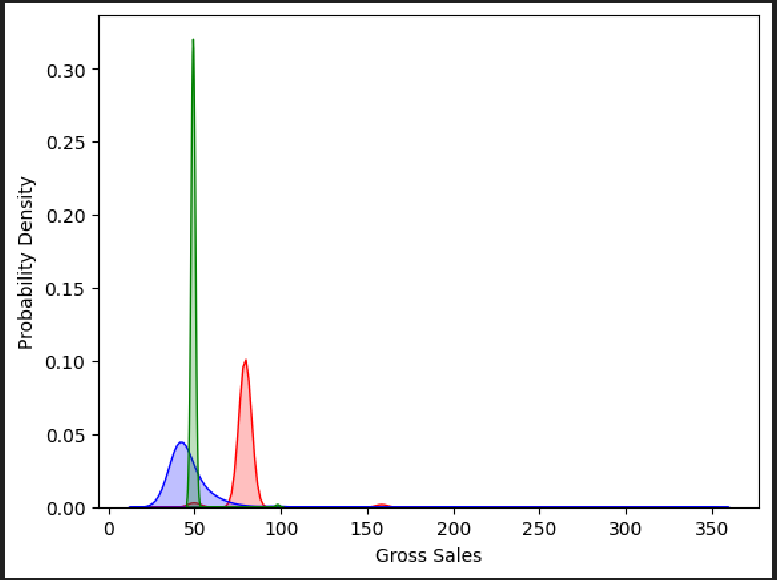

In [ ]:
df["day"] = df["day"].astype("string")

# Split column by year and month.
df["sale_year"] = df["day"].str.split("/").str[2]
df["sale_month"] = df["day"].str.split("/").str[0]

df_matcha = df[df["product_title"].isin(["Matcha Starter Kit"])]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
df_matcha = df_matcha.sort_values(by="sale_year", ascending=False)
ax = sns.countplot(data=df_matcha, x="sale_month", hue="sale_year")

# Sort the data by the month column
df_matcha = df_matcha.sort_values(by="sale_month")

# Convert the numbers on the x-axis into month names
month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
plt.xticks(range(0, 12), month_names)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Matcha Starter Kit sales by year", fontsize=20)
plt.xlabel("Months of the year", fontsize=13)
plt.ylabel("Value of sales", fontsize=13)
plt.rc("axes", labelsize=12)
handles, labels = ax.get_legend_handles_labels()
labels.sort()
ax.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.45, 1.30),
    frameon=False,
)

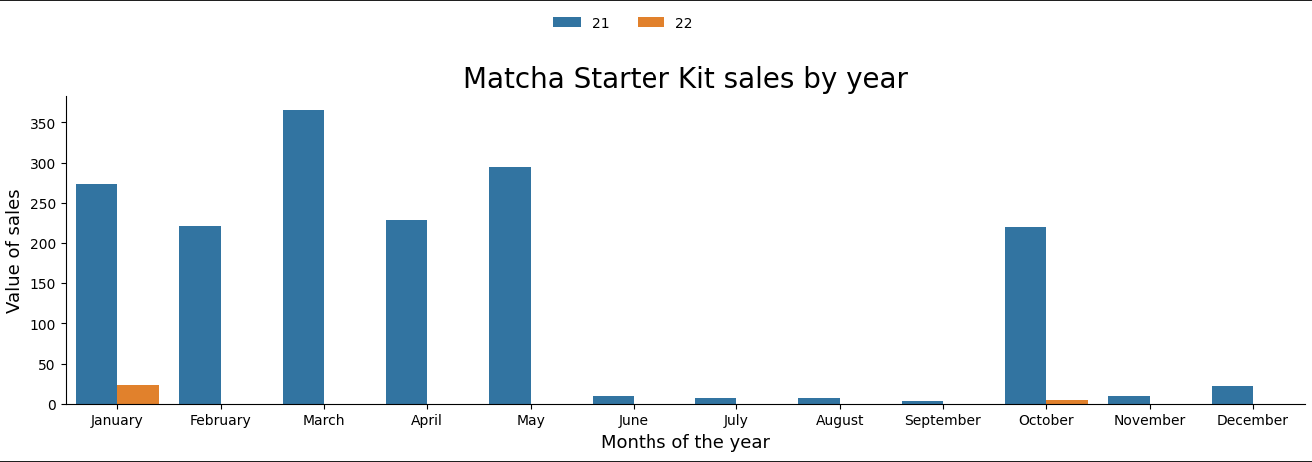

In [ ]:
df_latte_bundle = df[df["product_title"].isin(["Matcha & Hojicha Latte Bundle"])]

fig, ax = plt.subplots(figsize=(16, 4))
df_latte_bundle = df_latte_bundle.sort_values(by="sale_year", ascending=False)
ax = sns.countplot(data=df_latte_bundle, x="sale_month", hue="sale_year")

df_latte_bundle = df_latte_bundle.sort_values(by="sale_month")

month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
plt.xticks(range(0, 12), month_names)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Matcha & Hojicha Latte Bundle sales by year", fontsize=20)
plt.xlabel("Months of the year", fontsize=13)
plt.ylabel("Value of sales", fontsize=13)
plt.rc("axes", labelsize=12)
handles, labels = ax.get_legend_handles_labels()
labels.sort()
ax.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.45, 1.30),
    frameon=False,
)

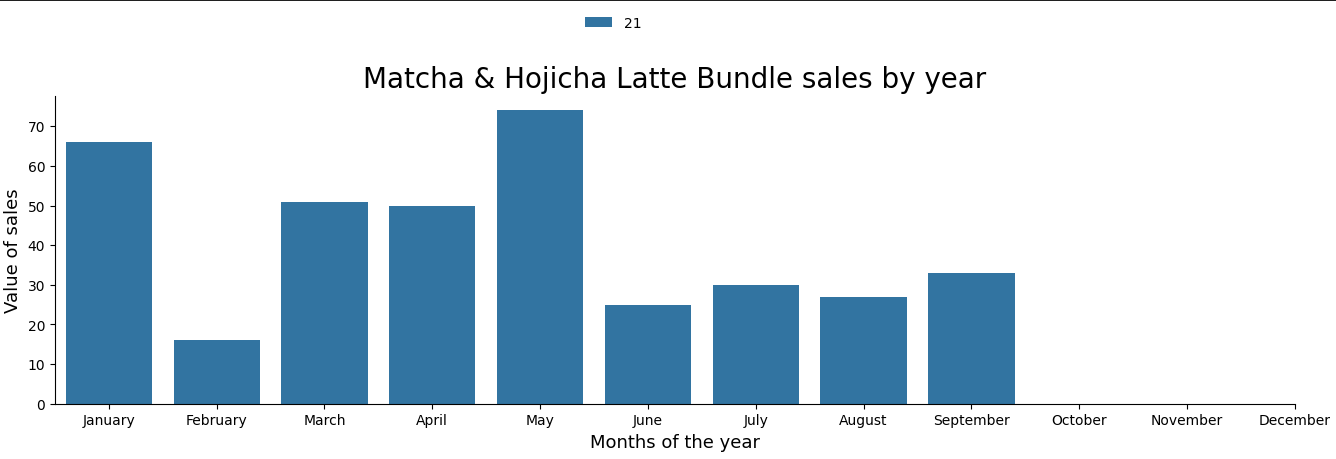

In [ ]:
df_matcha_cafe = df[df["product_title"].isin(["Matcha Home Cafe Kit"])]

fig, ax = plt.subplots(figsize=(16, 4))
df_matcha_cafe = df_matcha_cafe.sort_values(by="sale_year", ascending=False)
ax = sns.countplot(data=df_matcha_cafe, x="sale_month", hue="sale_year")

df_matcha_cafe = df_matcha_cafe.sort_values(by="sale_month")

month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
plt.xticks(range(0, 12), month_names)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Matcha Home Cafe kit sales by year", fontsize=20)
plt.xlabel("Months of the year", fontsize=13)
plt.ylabel("Value of sales", fontsize=13)
plt.rc("axes", labelsize=12)
handles, labels = ax.get_legend_handles_labels()
labels.sort()
ax.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.45, 1.30),
    frameon=False,
)

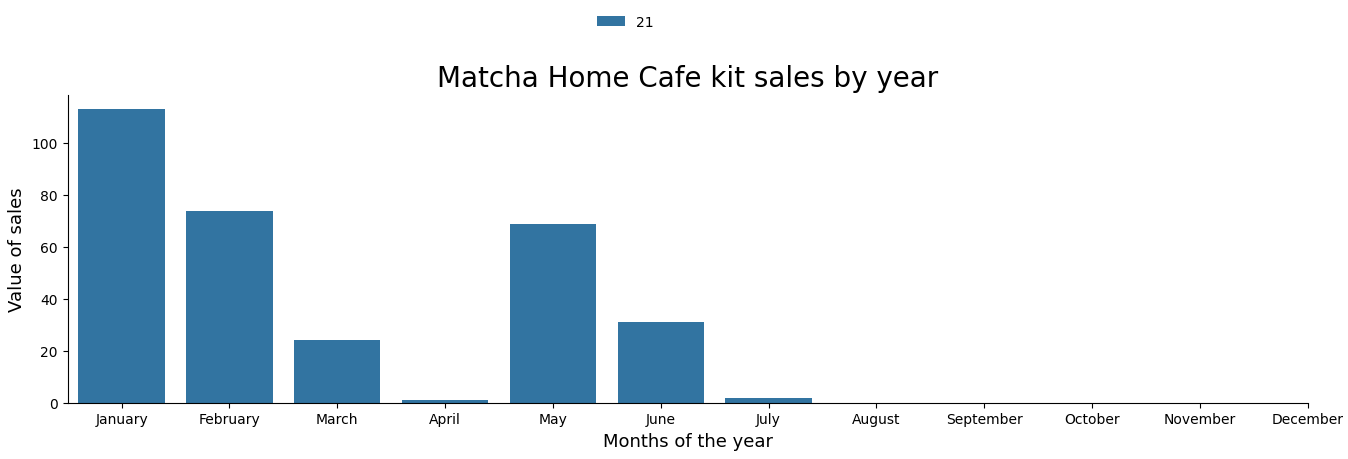

In [ ]:
df.describe(include="all").T

### Apriori Algorithm implementation

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
Basket = (
    df[df["product_type"] == "tea"]
    .groupby(["order_name", "product_title"])["net_quantity"]
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("order_name")
)

Basket.head()

In [ ]:
def sum_to_boolean(x):
    if x <= 0:
        return 0
    else:
        return 1

Basket_Final = Basket.applymap(sum_to_boolean)

### Frequent Itemsets - Matcha Starter Kits & Awakening Matcha Whisk Set

In [ ]:
## Apriori to select the most important itemsets
Frequent_itemsets = apriori(Basket_Final, min_support=0.05, use_colnames=True)

Frequent_itemsets.sort_values("support", ascending=False).head()

### Association Rules - Matcha Latte & Hijocha Latte

In [ ]:
Asso_Rules = association_rules(Frequent_itemsets, metric="lift", min_threshold=1)
Asso_Rules.sort_values("lift", ascending=False)

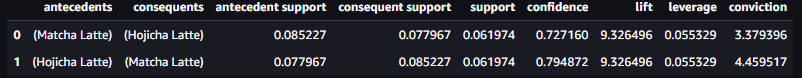

In [ ]:
Frequent_itemsets = apriori(Basket_Final, min_support=0.05, use_colnames=True)
Frequent_itemsets.sort_values("support", ascending=False).head()

Asso_Rules = association_rules(Frequent_itemsets, metric="confidence", min_threshold=0.5)
Asso_Rules.sort_values("confidence", ascending=False)

### Market Basket Analysis

In [ ]:
Basket_snack = (
    df[df["product_type"] == "snack"]
    .groupby(["order_name", "product_title"])["net_quantity"]
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("order_name")
)

# Basket_snack.head()
def sum_to_boolean(x):
    if x <= 0:
        return 0
    else:
        return 1


Basket_Final_snack = Basket_snack.applymap(sum_to_boolean)
Frequent_itemsets_snack = apriori(Basket_Final_snack, min_support=0.01, use_colnames=True)

Asso_Rules_snack = association_rules(Frequent_itemsets_snack, metric="lift", min_threshold=1)
Asso_Rules_snack.sort_values("lift", ascending=False).head()

In [ ]:
Basket_svi = (
    df[df["product_type"] == "svi_hidden"]
    .groupby(["order_name", "product_title"])["net_quantity"]
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("order_name")
)

# Basket_snack.head()
def sum_to_boolean(x):
    if x <= 0:
        return 0
    else:
        return 1


Basket_Final_svi = Basket_svi.applymap(sum_to_boolean)
Frequent_itemsets_svi = apriori(Basket_Final_svi, min_support=0.01, use_colnames=True)

Asso_Rules_svi = association_rules(Frequent_itemsets_svi, metric="lift", min_threshold=1)
Asso_Rules_svi.sort_values("lift", ascending=False).head()

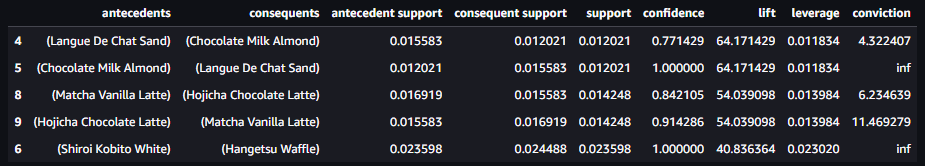

In [ ]:
import sys

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")


def hot_encode(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


product_vendor = "Craft Tea Fox"
customer_id = "5.211410e+12"


def apriori_model(product_vendor=product_vendor, customer_id=customer_id):
    data = df[df["product_vendor"] == product_vendor]
    today_date = max(data["day"])
    # RFM
    rfm = data.groupby("customer_id").agg(
        {
            "day": lambda Date: (today_date - day.max()).days,
            "customer_id": lambda customer_id: customer_id.count(),
            "gross_sales": lambda gross_sales: gross_sales.sum(),
        }
    )
    rfm.columns = ["recency", "frequency", "monetary"]
    scaler = StandardScaler().fit(rfm)
    rfm_scale = scaler.transform(rfm)
    # Kmeans
    kmeans = KMeans(n_clusters=4, n_init=25, max_iter=300)
    k_means = kmeans.fit(rfm_scale)
    segment = k_means.labels_
    rfm["segment"] = segment

    rfm = rfm.reset_index().rename(columns={"index": "customer_id"})
    new_df = data.merge(rfm, right_on="customer_id", left_on="customer_id")

    # Apriori

    number_of_cluster = list(rfm[rfm["customer_id"] == customer_id]["segment"])[0]

    apriori_df = new_df[new_df["segment"] == number_of_cluster]
    basket = (
        apriori_df.groupby(["order_name", "product_title"])["net_quantity"]
        .sum()
        .unstack()
        .reset_index()
        .fillna(0)
        .set_index("order_name")
    )
    # Encoding the datasets
    basket_encoded = basket.applymap(hot_encode)
    basket = basket_encoded

    frq_items = apriori(basket, min_support=0.03, use_colnames=True)
    rules = association_rules(frq_items, metric="lift", min_threshold=0.8)
    rules = rules.sort_values(["confidence", "lift"], ascending=[False, False])
    return rules


rules = apriori_model(product_vendor=product_vendor, customer_id=customer_id)
rules.head()

### RFM Analysis - Recency, Frequency and Monetary

In [ ]:
import datetime as datetime

date_1 = df["day"].max()
date_1 = datetime.datetime.strptime(date_1, "%m/%d/%y")


present = datetime.datetime(2022, 9, 30)
present_str = str(present)

# For each Customer ID, we calcualte the date last purchased, how many times they purchased and the toal money spent
df_rfm = df.groupby("customer_id").agg(
    {
        "day": lambda date: (present - date_1).days,
        "order_name": lambda num: len(num),
        "gross_sales": lambda price: price.sum(),
        "product_title": lambda stock: list(stock),
    }
)
df_rfm

In [ ]:
# We bin customers into profiles
df_rfm["r_quartile"] = pd.qcut(df_rfm["recency"].rank(method="first"), 4, ["1", "2", "3", "4"])
df_rfm["f_quartile"] = pd.qcut(df_rfm["frequency"].rank(method="first"), 4, ["1", "2", "3", "4"])
df_rfm["m_quartile"] = pd.qcut(df_rfm["monetary"].rank(method="first"), 4, ["1", "2", "3", "4"])
df_rfm

### Customer Segmentation by RFM groups

In [ ]:
df_rfm["rfm_segment"] = (
    df_rfm.r_quartile.astype(str) + df_rfm.f_quartile.astype(str) + df_rfm.m_quartile.astype(str)
)
#df_rfm.head()

# To find the most frequently purchased item in each segment
df_rfm1 = df_rfm
df_rfm2 = df_rfm1.explode("product_title")
df_rfm2


### Top Customers' RFM Segments

In [ ]:
import numpy as np

df_rfm2["rfm_segment"] = df_rfm2["rfm_segment"].astype(int)
df_rfm2["customer_segment"] = np.where(
    df_rfm2["rfm_segment"] < 150,
    "top customers",
    (
        np.where(
            df_rfm2["rfm_segment"] < 250,
            "high value customers",
            (
                np.where(
                    df_rfm2["rfm_segment"] < 350,
                    "medium value customers",
                    np.where(df_rfm2["rfm_segment"] < 450, "low value customers", "lost customers"),
                )
            ),
        )
    ),
)
df_rfm2

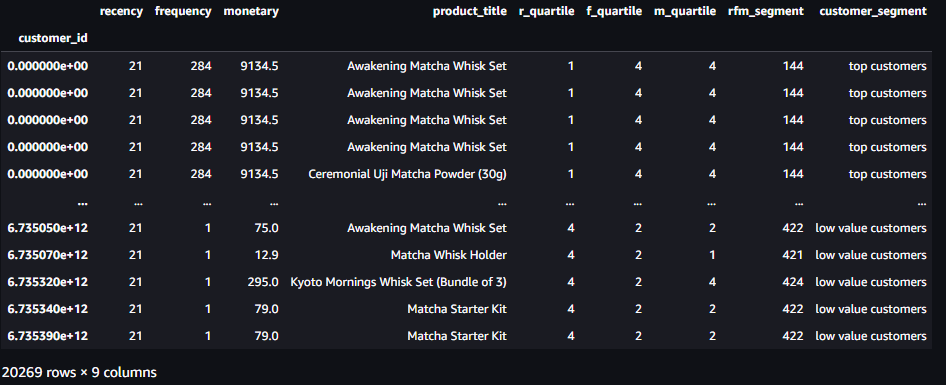

In [ ]:
from matplotlib import pyplot as plt

plt.pie(
    df_rfm2.customer_segment.value_counts(),
    labels=df_rfm2.customer_segment.value_counts().index,
    autopct="%.0f%%",
)
plt.show()

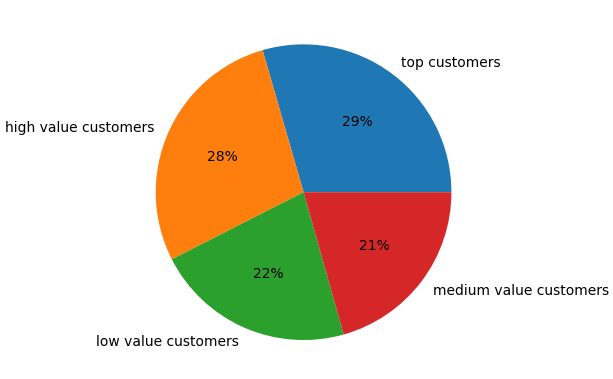

In [ ]:
# The most purchased item in each rfm segment
df_rfm3 = df_rfm2.groupby("rfm_segment")["product_title"].agg(pd.Series.mode)
df_rfm3

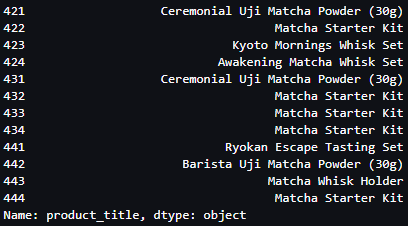

### Top 3 customers of each RFM segment

In [ ]:
# Define a function to select the top 3 rows of each group
def top_n(df, n=2, column="monetary"):
    return df.nlargest(n, column)


# Group the dataframe by 'rfm_segment' and apply the 'top_n' function to each rfm segment
top3_rfm = df_rfm2.groupby("rfm_segment").apply(top_n, n=3, column="monetary")
top3_rfm

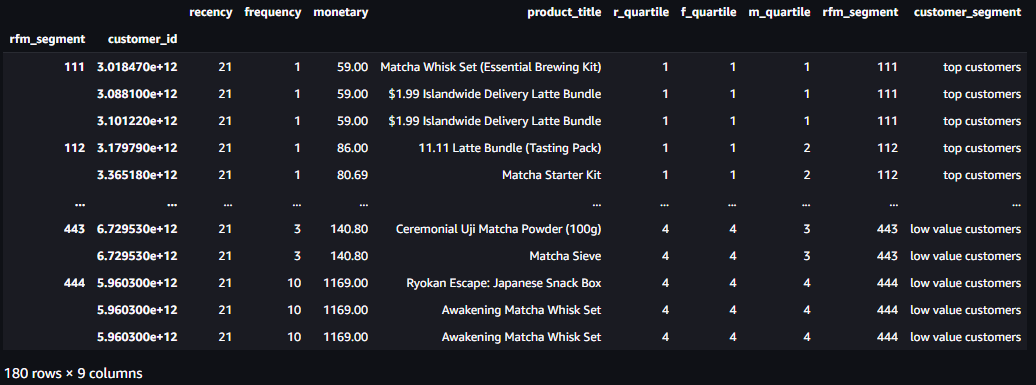

In [ ]:
df = pd.read_csv("s3://bcg-rise-prod-sagemaker-input-data/wave-2/SalesData.csv")
df["product_type"] = df["product_type"].fillna("tea")
df = df.dropna()
cols = df.columns.drop(["product_title", "product_vendor", "product_type", "day"])
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")  # convert cols to numeric

df = df[df["net_quantity"] >= 0]

In [ ]:
date_1 = df["day"].max()
date_1 = datetime.datetime.strptime(date_1, "%m/%d/%y")


present = datetime.datetime(2022, 9, 30)
present_str = str(present)

# For each Customer ID, we calcualte the date last purchased, how many times they purchased and the toal money spent
df_rfm = df.groupby("customer_id").agg(
    {
        "day": lambda date: (present - date_1).days,
        "order_name": lambda num: len(num),
        "gross_sales": lambda price: price.sum(),
        "product_title": lambda stock: list(stock),
    }
)
df_rfm.head()

In [ ]:
df_rfm_k = df_rfm.copy()
df_rfm_k.columns = ["recency", "frequency", "monetary", "product_title"]
df_rfm_k.drop(columns=df_rfm_k.columns[-1], axis=1, inplace=True)
df_rfm_k.head()

### K Means Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm_k)  # k means clustering

In [ ]:
inertia = []
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import style
from sklearn.cluster import KMeans

style.use("ggplot")
sns.set_palette("bright")
from warnings import filterwarnings

filterwarnings("ignore")
import os

for i in np.arange(1, 6):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(inertia, marker="o")
plt.title("KMeans - Elbow", fontsize=18)
plt.show()

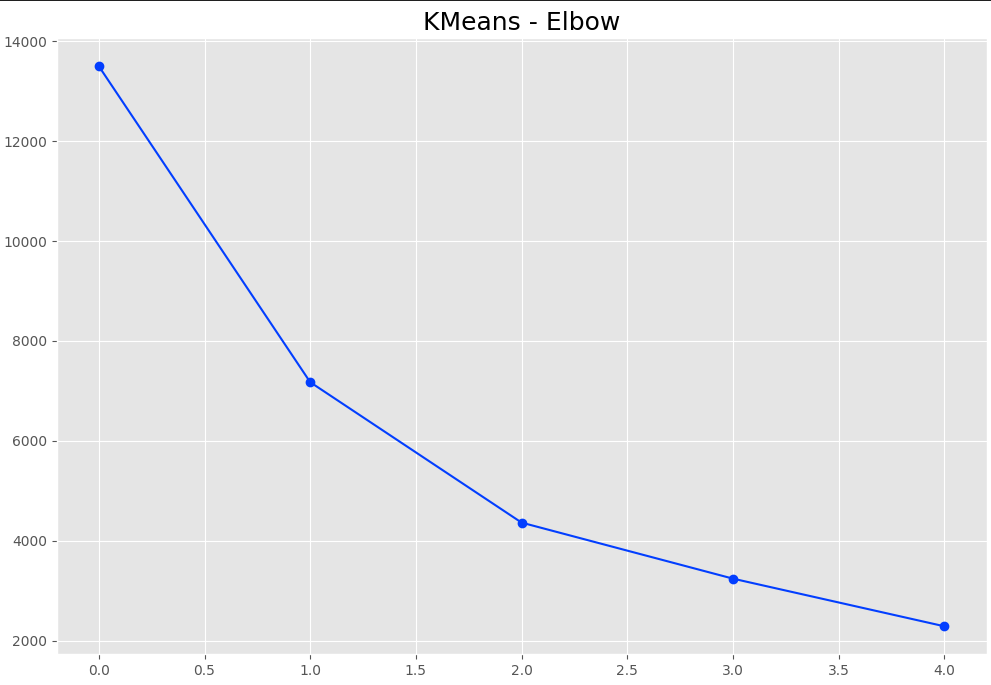

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_scaled)
df_rfm_k["Cluster_No"] = kmeans.labels_ + 1
df_rfm_k.head()

### 3 Customer Clusters

In [ ]:
df_rfm_k.groupby(["Cluster_No"])[["recency", "frequency", "monetary"]].mean()

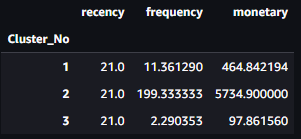

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(df_rfm_k.Cluster_No)
plt.title("Number of Clusters", fontsize=20)
for bars in ax.containers:
    ax.bar_label(bars)
ax

In [ ]:
df = pd.read_csv("s3://bcg-rise-prod-sagemaker-input-data/wave-2/SalesData.csv")
df["product_type"] = df["product_type"].fillna("tea")
df = df.dropna()
cols = df.columns.drop(["product_title", "product_vendor", "product_type", "day"])
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")  # convert cols to numeric

df = df[df["net_quantity"] >= 0]

### Transaction Encoder - mlxtend

In [ ]:
df_z = df[df.net_quantity.gt(0)]
df_zz = df_z.groupby("customer_id")["product_title"].apply(list).reset_index(name="product_titles")

In [ ]:
def remove_dup_list(lst):
    return list(dict.fromkeys(lst))


for i in range(len(df_zz)):
    lst = df_zz.iat[i, 1]
    df_zz.iat[i, 1] = remove_dup_list(lst)

# pd.DataFrame(df_zz.product_titles.values.tolist()).add_prefix('product_')
f = lambda x: "product_{}".format(x + 1)
df_zzz = (
    pd.DataFrame(df_zz.product_titles.values.tolist(), df_zz.index, dtype=object)
    .fillna("")
    .rename(columns=f)
)
#df_zzz.head()

In [ ]:
lst_zzz = df_zzz.values.tolist()

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
transactions = encoder.fit(lst_zzz).transform(lst_zzz)

transactions = transactions.astype("int")
df_zzz_encode = pd.DataFrame(transactions, columns=encoder.columns_)

df_zzz_encode.head()

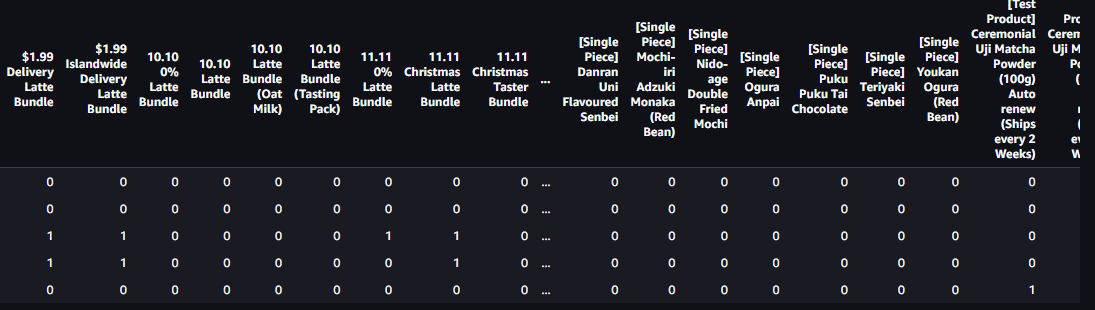

In [ ]:
frequent_itemsets_zzz = apriori(df_zzz_encode, min_support=0.02, use_colnames=True)
frequent_itemsets_zzz["length"] = frequent_itemsets_zzz["itemsets"].apply(lambda x: len(x))

frequent_itemsets_zzz.sort_values(by="support", ascending=False)

In [ ]:
# find top 10 items with minimum support of 3%
frequent_itemsets_zzz[
    (frequent_itemsets_zzz["length"] == 1) & (frequent_itemsets_zzz["support"] >= 0.03)
][0:10]

In [ ]:
# find itemsets having length more than 1 and minimum support of 10%
frequent_itemsets_zzz[
    (frequent_itemsets_zzz["length"] > 1) & (frequent_itemsets_zzz["support"] >= 0.1)
]

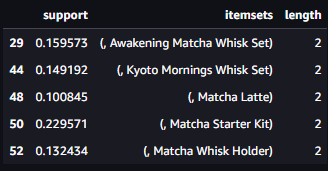

### Association Rules

In [ ]:
asso_rules = association_rules(frequent_itemsets_zzz, metric="support", min_threshold=0.05)
asso_rules

In [ ]:
# sort rules in the descending order by confidence
asso_rules.sort_values(by="confidence", ascending=False)[0:10]

### Association Rules with min Support 3% and Lift > 2

In [ ]:
# find association rules with minimum support of 5% and having lift more than 2
asso_rules[(asso_rules["support"] >= 0.05) & (asso_rules["lift"] > 2.0)]

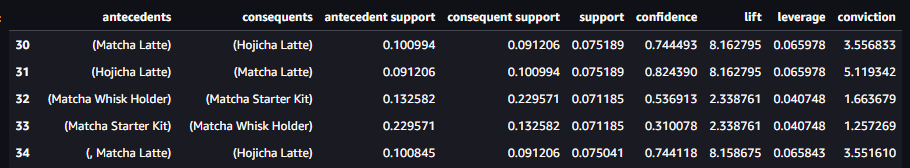

### Transaction Encoder (groupby order_name)

In [ ]:
df_x = df[df.net_quantity.gt(0)]
df_xx = df_x.groupby("order_name")["product_title"].apply(list).reset_index(name="product_titles")

In [ ]:
def remove_dup_list(lst):
    return list(dict.fromkeys(lst))


for i in range(len(df_xx)):
    lst = df_xx.iat[i, 1]
    df_xx.iat[i, 1] = remove_dup_list(lst)


In [ ]:
# pd.DataFrame(df_zz.product_titles.values.tolist()).add_prefix('product_')
f = lambda x: "product_{}".format(x + 1)
df_xxx = (
    pd.DataFrame(df_xx.product_titles.values.tolist(), df_xx.index, dtype=object)
    .fillna("")
    .rename(columns=f)
)
#df_xxx.head()

### Encode to 1 and 0

In [ ]:
lst_xxx = df_xxx.values.tolist()

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
transactions = encoder.fit(lst_xxx).transform(lst_xxx)

transactions = transactions.astype("int")
df_xxx_encode = pd.DataFrame(transactions, columns=encoder.columns_)

#df_xxx_encode.head()

### Frequent Itemsets by Support

In [ ]:
frequent_itemsets_xxx = apriori(df_xxx_encode, min_support=0.02, use_colnames=True)
frequent_itemsets_xxx["length"] = frequent_itemsets_xxx["itemsets"].apply(lambda x: len(x))

frequent_itemsets_xxx.sort_values(by="support", ascending=False)

### Frequent Itemsets min Support 3%

In [ ]:
# find top 10 items with minimum support of 3%
frequent_itemsets_xxx[
    (frequent_itemsets_xxx["length"] == 1) & (frequent_itemsets_xxx["support"] >= 0.03)
][0:10]

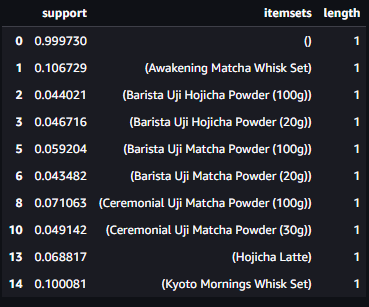

### Frequent Itemsets with high Support threshold

In [ ]:
# find itemsets having length more than 1 and minimum support of 10%
frequent_itemsets_xxx[
    (frequent_itemsets_xxx["length"] > 1) & (frequent_itemsets_xxx["support"] >= 0.1)
]

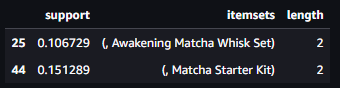

In [ ]:
asso_rules = association_rules(frequent_itemsets_xxx, metric="support", min_threshold=0.05)
#asso_rules

# sort rules in the descending order by confidence
asso_rules.sort_values(by="confidence", ascending=False)[0:10]

# sort rules in the descending order by support and lift
asso_rules.sort_values(by=["support", "lift"], ascending=False)[0:10]

### Association Rules min Support 5% and Lift > 2

In [ ]:
# find association rules with minimum support of 5% and having lift more than 2
asso_rules[(asso_rules["support"] >= 0.05) & (asso_rules["lift"] > 2.0)]

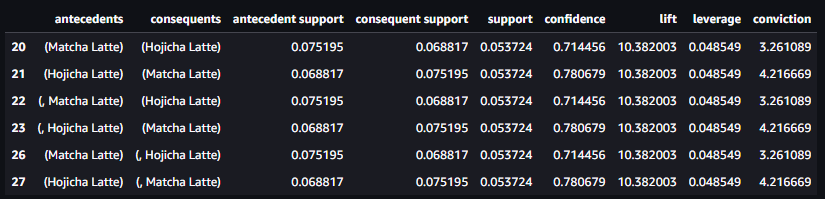